In [ ]:
%plot inline -w 600 -h 600 -r 150

# 8 Optimization - Neural Networks - More networks

## Learning in a better way - gradient descent!

Let's return to our very simple model of neurons, for which we said that we can write their output as the activation function applied to the linearly weighted input:
$$
\vec{y}=f(\vec{w}^{\top}\vec{x})
$$


Now, we need to find a way to **learn** the weights $\vec{w}$ somehow. 

In the previous perceptron examples, we did this by updating the weights with the class-weighted sample - $\vec{w}=\vec{w}+y_k\vec{x}_k$, but how would we do this in a general case?

Let's try to do **gradient descent**!!

Let's again go to our standard way of doing things and minimize the least squares error of some target values $\vec{t}$ versus the prediction:

$$
E(\vec{w})=\frac{1}{2} \sum \|\vec{y(\vec{w})}-\vec{t}\|^2
$$

Now we remember that the output is some kind of function of the weighted sum of all inputs $\vec{x}$, i.e., $\vec{y}=f(\vec{w}^{\top}\vec{x})$, so we can take the derivative:

$$
\frac{\partial E(\vec{w})}{\partial \vec{w}}= \left ( f(\vec{w}^{\top}\vec{x})-\vec{y}\right ) \frac{\partial f(\vec{w}^{\top}\vec{x})}{\partial \vec{w}}
$$

$$
=\left ( f(\vec{w}^{\top}\vec{x})-\vec{y}\right )\vec{x} \frac{\partial f(\vec{w}^{\top}\vec{x})}{\partial(\vec{w}^{\top}\vec{x})}
$$

So, once we've decided on an activation function, we can determine this derivative.

#### $f=x$

If the activation function $f$ is simply the identity function $f(\vec{i}) = \vec{i}$, then this derivative becomes very simple:

$$
\frac{\partial E(\vec{w})}{\partial \vec{w}}=\left ( \vec{w}^{\top}\vec{x}-\vec{y}\right )\vec{x} 
$$

So, now our update for the gradient can be calculated, and it will be:

$$
-\lambda\frac{\partial E(\vec{w})}{\partial \vec{w}}=-\lambda \left ( \vec{w}^{\top}\vec{x}-\vec{y}\right )\vec{x} 
$$

#### $f=\frac{1}{1+e^{-x}}$

If the activation function $f$ is the logistic function $f=\frac{1}{1+e^{-\vec{w}^{\top}\vec{x}}}$, then this derivative becomes:

$$
\frac{\partial E(\vec{w})}{\partial \vec{w}}=\left ( f(\vec{w}^{\top}\vec{x})-\vec{y}\right )\vec{x}f(\vec{w}^{\top}\vec{x})(1-f(\vec{w}^{\top}\vec{x})) 
$$

#### $f=\text{ReLU}=\max(0,x)$

This function is not differentiable at $x=0$, so we will arbitrarily say that

$$
f'(x)=\left \{ \begin{array}{cc}1&: x>0\\0&:x\leq 0 \end{array} \right .
$$

## Multi-layer networks: Backpropagation
Now, this approach is all fine, if we only have ONE neuron, but what about multiple, connected neurons that live in different layers?

The error in the output of an arbitrary neuron in a neural network will depend on all previous weights, so if we want to do gradient descent, we need to somehow know how to derive this.

Again, we assume that each neuron $j$ will provide an output $y_j$, which is defined as the weighted sum of inputs pushed through the activation function:

$$
y_j = f(\vec{w}\vec{x})=f(\sum w_{kj}x_k)
$$

So, the derivative of the total error with respect to any weight $w_{ij}$ is done using the full sets of dependents:

$$
\frac{\partial E}{\partial w_{ij}}=\frac{\partial E}{\partial y_{j}}\frac{\partial y_j}{\partial w_{ij}}=\frac{\partial E}{\partial y_{j}}\frac{\partial y_j}{\partial (\sum w_{kj}y_k)}\frac{\partial (\sum w_{kj}y_k)}{\partial w_{ij}}
$$

Let's look at the three terms. Let's start with the second term, which is the derivative of the error function. Let's assume it's the logistic function, which has the neat and simple derivative from above

$$
\frac{\partial y_j}{\partial (\sum w_{kj}y_k)}=...
$$

For the third term we observe that in the sum only one term contains the actual derivative weight $w_{ij}$, so that becomes:

$$
\frac{\partial (\sum w_{kj}y_k)}{\partial w_{ij}}=...
$$

Now, for the first term, we distinguish two cases: if the neuron is in the final layer, then $y_j=y_{end}$, which means:

$$
\frac{\partial E}{\partial y_{j}}=\frac{\partial E}{\partial y_{end}}= \frac{\partial}{\partial y_{end}}\frac{1}{2}(t-y_{end})^2=...
$$

For "inner" neurons $j$ in other layers, however, this term needs to be evaluated with respect to earlier layers as well, since the error term depends on the outputs of all neurons connected to the present neuron. Let's put all these $a$ connected neurons into one set $N=\{n_{1j},\dots,n_{aj}\}$

$$
\frac{\partial E(y_{j})}{\partial y_{j}}=
\sum_{n\in N}\left ( \frac{\partial E}{\partial (\sum w_{nj}y_n)}\frac{\partial (\sum w_{nj}y_n)}{\partial y_j} \right )=\sum_{n\in N}\left ( \frac{\partial E}{\partial y_n}\frac{\partial y_n}{\partial (\sum w_{nj}y_n)}\frac{\partial (\sum w_{nj}y_n)}{\partial y_j} \right )=\sum_{n\in N}\left ( \frac{\partial E}{\partial y_n}\frac{\partial y_n}{\partial (\sum w_{nj}y_n)}w_{jn} \right )
$$

This means that we can calculate the derivative, once we know all of the derivatives with respect to the downstream connected neurons are known. This is why this is called backpropagation, since in order to run the algorithm, you start from the output layer, and then proceed backwards through the network!

In total, we get for a logistic activation function:

$$
\frac{\partial E}{\partial w_{ij}}=y_i\alpha_j
$$

with 
$$
\alpha_j:=\frac{\partial y_j}{\partial (\sum w_{kj}y_k)}\frac{\partial (\sum w_{kj}y_k)}{\partial w_{ij}}=\left \{ \begin{array}{ll}... &: \text{if }j\text{ is an output layer neuron}\\...&: \text{if }j\text{ is an inner/hidden layer neuron} \end{array}\right .
$$


### Example implementation

Here's an example implementation that learns a simple one hidden-layer network with a few neurons in order to approximate a $f(x,y)=x^2+y^2+1$.

We generate 400 input/output value pairs and then try to learn the whole thing using our update rules from above.

Just for fun, here we are going to use the ReLU function instead of the logistic function. 

In [1]:
%%file oneHiddenLayerRegressionNetwork.m

function oneHiddenLayerRegressionNetwork(hidden_layer_size,numEpochs,lr)
input_layer_size = 2;
output_layer_size = 1;

% init weights
Wh = randn(input_layer_size, hidden_layer_size) * sqrt(2.0/input_layer_size);
Wo = randn(hidden_layer_size, output_layer_size) * sqrt(2.0/hidden_layer_size);

% init biases
Bh = ones(1, hidden_layer_size)*0.1;
Bo = ones(1, output_layer_size)*0.1;

% create data for regression
xs=linspace(-2,2,20);
ys=linspace(-2,2,20);
counter=1;
data=[];
labels=[];
for r=1:length(xs)
    for c=1:length(ys)
        data(counter,:)=[xs(r) ys(c)];
        labels(counter,1)=xs(r)^2+ys(c)^2+1;
        counter=counter+1;
    end
end

% normalize data
data(:,1)=data(:,1)/norm(data(:,1));
data(:,2)=data(:,2)/norm(data(:,2));

numData = size(data,1);

% learning rate
lr = .001;


%% main loop
for iter=1:numEpochs
    % this is stochastic gradient descent
    for j = 1:numData
        % select a random data point
        selectedInd = 1+floor(rand*numData);
        % set the current data
        selectedData = data(selectedInd,:);
        selectedLabel = labels(selectedInd);
        % do one step of backpropagation on that data
        [Wh,Wo]=backprop(selectedData, selectedLabel, Wh, Bh, Wo, Bo, lr);
    end
    % write out result (one hundred epochs !!)
    if mod(iter,100)==0
        [yHat,Zo,Zh,H] = feed_forward(data, Wh, Bh, Wo, Bo);
        fprintf('iter %05d: %f\n',iter,loss(yHat,labels));
    end
end
%% check final result
[yHat,Zo,Zh,H] = feed_forward(data, Wh, Bh, Wo, Bo);
fprintf('iter %05d: %f\n',iter,loss(yHat,labels));
[xsm,ysm]=meshgrid(xs,ys);
figure(101);
subplot(1,2,1)
surf(xsm,ysm,xsm.^2+(ysm.^2)+1)
subplot(1,2,2)
surf(xsm,ysm,reshape(yHat,length(xs),length(xs)))
end

%% this is the relu activation function
function r = relu(Z)
    r = max(0, Z);
end

%% this is the feed_forward function
function [yHat,Zo,Zh,H] = feed_forward(X,Wh,Bh,Wo,Bo)
    %
    %X    - input matrix
    %Zh   - hidden layer weighted input
    %Zo   - output layer weighted input
    %H    - hidden layer activation
    %y    - output layer
    %yHat - output layer predictions
    %

    % Hidden layer function
    Zh = X*Wh + repmat(Bh,size(X,1),1); % adds the bias
    H = relu(Zh); % stick it into acti func.

    % Output layer function
    Zo = H*Wo + repmat(Bo,size(X,1),1); % Output weight
    yHat = relu(Zo); 
end

%% derivative of relu
function o = relu_der(z) 
    o = double(z > 0); % boolean problem 
end

%% calculate loss 
function l = loss(yHat, y)
    l= 0.5 * (yHat - y)'*(yHat-y);
end

%% derivative of loss 
function ld = loss_der(yHat, y)
    ld= yHat - y;
end

%% backpropagation step 
function [Wh,Wo]=backprop(data, labels, Wh, Bh, Wo, Bo, lr)
    % push the data through the network
    [yHat,Zo,Zh,H] = feed_forward(data, Wh, Bh, Wo, Bo);
    
    % layer errors for output layer
    Eo = (yHat - labels).* double(Zo>0);
    % layer error for input layer
    Eh = Eo .* double(Zh>0) ;

    % loss derivative for weight of output layer
    dWo = Eo*H;
    
    % loss derivative for weight of hidden layer
    dWh = Eh'* data;

    % update weights
    Wh = Wh-lr * dWh'; % learning rate
    Wo = Wo-lr * dWo';
end


Created file '/Users/sucky/Desktop/MATLAB_for_Engineering_Math_Projects/ENG_MATH/5:14/oneHiddenLayerRegressionNetwork.m'.


### Experiments

Let's try to get a feeling for this:

iter 00100: 914.142627
iter 00200: 390.098226
iter 00300: 329.196267
iter 00400: 313.520504
iter 00500: 299.345208
iter 00600: 285.277837
iter 00700: 272.424985
iter 00800: 261.142583
iter 00900: 251.225118
iter 01000: 242.742227
iter 01100: 235.027443
iter 01200: 227.997329
iter 01300: 221.803510
iter 01400: 216.332060
iter 01500: 211.375940
iter 01600: 206.930721
iter 01700: 202.857151
iter 01800: 199.047739
iter 01900: 195.604540
iter 02000: 192.324986
iter 02000: 192.324986


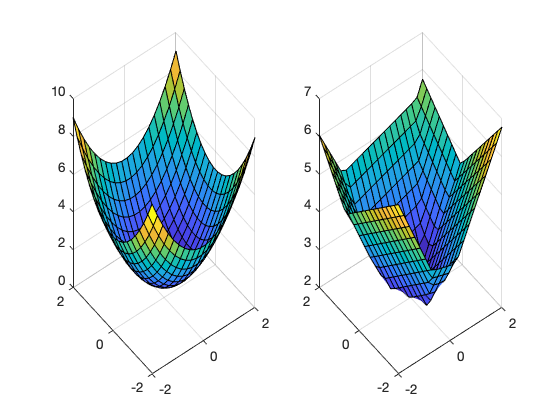

In [6]:
oneHiddenLayerRegressionNetwork(3,2000,.001) % loss function goes down

%original function =>

% what's wrong => epoch not long enough

iter 00100: 600.574273
iter 00200: 537.851547
iter 00300: 480.163196
iter 00400: 422.490206
iter 00500: 371.175169
iter 00600: 323.537298
iter 00700: 278.871088
iter 00800: 238.942307
iter 00900: 204.892271
iter 01000: 175.450192
iter 01000: 175.450192


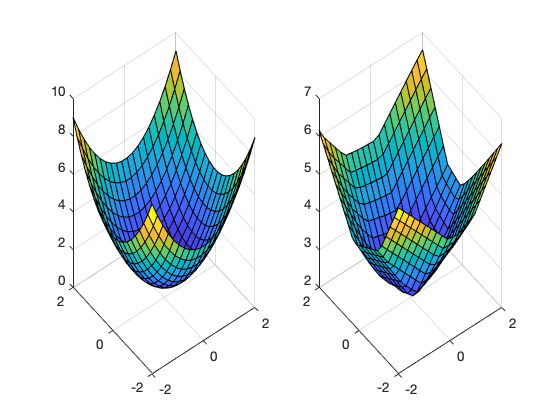

In [7]:
oneHiddenLayerRegressionNetwork(10,1000,.001)

iter 00100: 514.269195
iter 00200: 427.350544
iter 00300: 353.055602
iter 00400: 292.122237
iter 00500: 241.741806
iter 00600: 200.505545
iter 00700: 165.608128
iter 00800: 136.772315
iter 00900: 114.385805
iter 01000: 97.497727
iter 01000: 97.497727


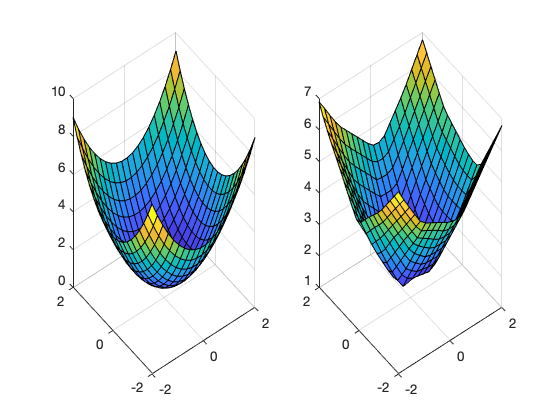

In [8]:
oneHiddenLayerRegressionNetwork(20,1000,.001)

iter 00100: 515.580274
iter 00200: 424.677850
iter 00300: 347.128683
iter 00400: 282.294134
iter 00500: 227.529371
iter 00600: 182.757573
iter 00700: 147.644514
iter 00800: 120.625095
iter 00900: 100.349255
iter 01000: 84.754432
iter 01100: 72.482590
iter 01200: 62.563951
iter 01300: 55.023282
iter 01400: 49.160804
iter 01500: 44.397090
iter 01600: 40.484079
iter 01700: 37.326541
iter 01800: 34.683965
iter 01900: 32.637422
iter 02000: 30.973505
iter 02100: 29.778237
iter 02200: 29.076738
iter 02300: 28.963608
iter 02400: 29.516027
iter 02500: 30.934625
iter 02600: 33.042484
iter 02700: 35.856645
iter 02800: 39.121549
iter 02900: 42.428422
iter 03000: 45.860861
iter 03100: 49.156219
iter 03200: 52.221379
iter 03300: 55.204340
iter 03400: 57.992171
iter 03500: 60.442914
iter 03600: 62.487888
iter 03700: 64.403802
iter 03800: 66.145532
iter 03900: 67.670072
iter 04000: 69.011757
iter 04100: 70.189121
iter 04200: 71.242105
iter 04300: 72.151970
iter 04400: 72.922692
iter 04500: 73.460161
i

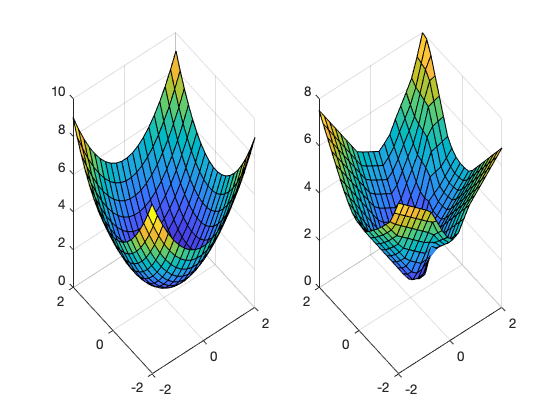

In [9]:
oneHiddenLayerRegressionNetwork(20,5000,.001)

# You could approximate any function
## onelayer - non linear => approximation is possible. 

### problem is ...
### How many neuron to be proper.

### One Hidden Layer is not enough